In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
from matplotlib import pyplot
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
DEFAULT_SIZE = 8 # number of circuit inputs
NUMBER_OF_SHOTS = 2048
workspace = Workspace(resource_id=os.environ['RESOURCE_ID'], location=os.environ['LOCATION_ID'])
provider = AzureQuantumProvider(workspace)

In [3]:
print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.simulator
- ionq.qpu
- ionq.qpu.aria-1
- ionq.qpu.aria-2
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1e
- quantinuum.qpu.h1-1
- rigetti.sim.qvm
- rigetti.qpu.ankaa-2
- microsoft.estimator


In [4]:
ionq_simulator = provider.get_backend("ionq.simulator")
ionq_qpu = provider.get_backend("ionq.qpu")
ionq_qpu_aria_1 = provider.get_backend("ionq.qpu.aria-1")
rigetti_qpu_ankaa_2 = provider.get_backend("rigetti.qpu.ankaa-2")
quantinuum_qpu = provider.get_backend("quantinuum.qpu.h1-1")

In [5]:
import random

# create an array of length n containing random boolean values (i.e a random bit string)
def random_bitstring(n = DEFAULT_SIZE):
    bit_str = []
    for i in range (n):
        bit_str.append(random.randint(0,1))
    return bit_str

In [6]:
def alice(circ, n = DEFAULT_SIZE, bit_str = None, enc = None):
    # unless specified generate a random key
    key = bit_str if bit_str is not None else random_bitstring(n)
    # unless specified generate a random basis encoding
    basis = enc if enc is not None else random_bitstring(n)
    for i in range(n):
        # set the state to match the key
        if (key[i]): 
            circ.x(i)
        # set the state to match tha basis encoding
        if (basis[i]):
            circ.h(i)
  
    return key, basis

In [7]:
def bob(circ, n = DEFAULT_SIZE, enc = None):
    # unless specified generate a random basis encoding
    basis = enc if enc is not None else random_bitstring(n)
    for i in range(n):
        # set the state to match the basis encoding
        if (basis[i]):
            circ.h(i)
  
    return basis

[1, 1, 1, 1, 0, 1, 0, 1]
[0, 0, 1, 0, 0, 1, 0, 1]
[0, 0, 1, 0, 1, 0, 1, 0]


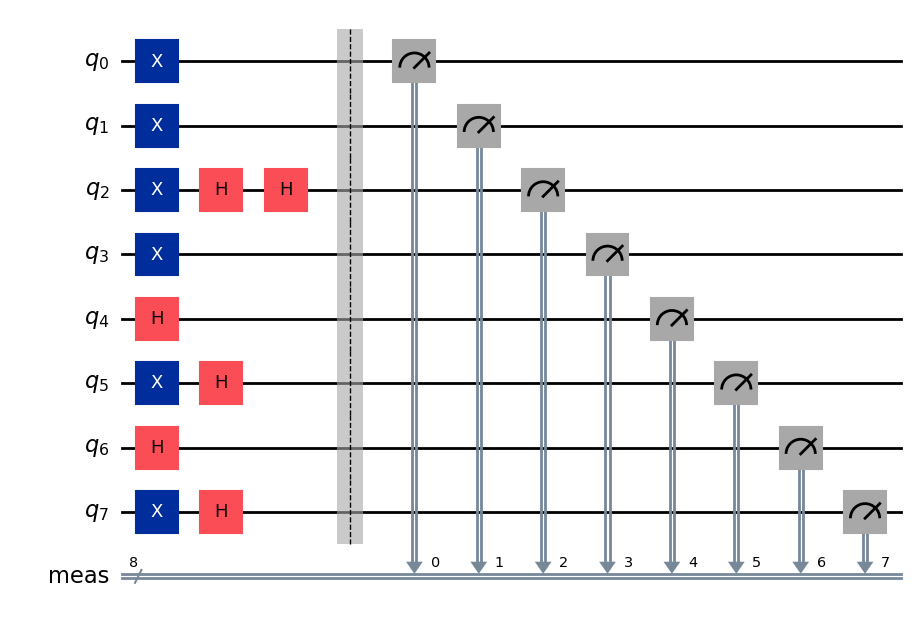

In [23]:
c = QuantumCircuit(DEFAULT_SIZE)
key, alice_basis = alice(c)
bob_basis = bob(c)

c.measure_all()

print(key)
print(alice_basis)
print(bob_basis)

c.draw('mpl')

In [9]:
def run(circ, backend):
    qc_compiled = transpile(circ, backend)
    job_sim = backend.run(qc_compiled, shots=NUMBER_OF_SHOTS)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc_compiled)
    return counts

.......

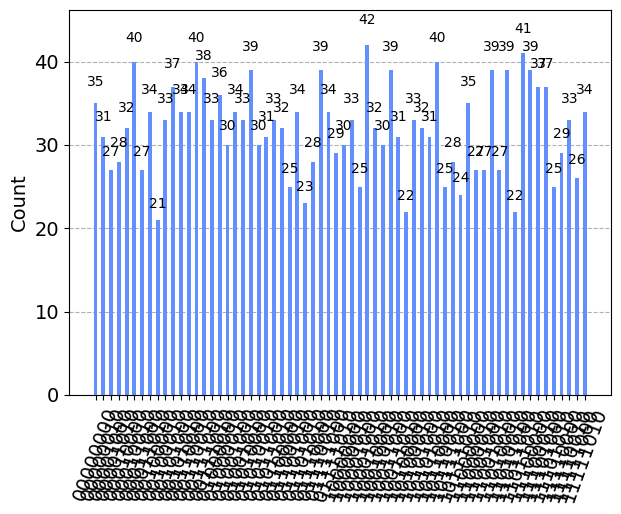

In [10]:
# Run the circuit on a simulator
counts_sim = run(c, ionq_simulator)
plot_histogram(counts_sim)

In [15]:
print(counts_sim)

{'00000000': 35, '00000010': 31, '00001000': 27, '00001010': 28, '00010000': 32, '00010010': 40, '00011000': 27, '00011010': 34, '00100000': 21, '00100010': 33, '00101000': 37, '00101010': 34, '00110000': 34, '00110010': 40, '00111000': 38, '00111010': 33, '01000000': 36, '01000010': 30, '01001000': 34, '01001010': 33, '01010000': 39, '01010010': 30, '01011000': 31, '01011010': 33, '01100000': 32, '01100010': 25, '01101000': 34, '01101010': 23, '01110000': 28, '01110010': 39, '01111000': 34, '01111010': 29, '10000000': 30, '10000010': 33, '10001000': 25, '10001010': 42, '10010000': 32, '10010010': 30, '10011000': 39, '10011010': 31, '10100000': 22, '10100010': 33, '10101000': 32, '10101010': 31, '10110000': 40, '10110010': 25, '10111000': 28, '10111010': 24, '11000000': 35, '11000010': 27, '11001000': 27, '11001010': 39, '11010000': 27, '11010010': 39, '11011000': 22, '11011010': 41, '11100000': 39, '11100010': 37, '11101000': 37, '11101010': 25, '11110000': 29, '11110010': 33, '111110

In [16]:
# given a measurement of the state find the candidate for a shared key from the encoding basis of alice and bob
def find_shared_key(measured):
    shared_key = []
    for i in range(len(alice_basis)):
        # if alice and bob agree on the encoding basis add the corresponding bit to the candidate key
        if alice_basis[i] == bob_basis[i]:
            shared_key.append(int(measured[i]))
    return shared_key

In [17]:
alice_shared_key = find_shared_key(key)
print(alice_shared_key)

# seemingly qiskit prints the states in reverse order, so we reverse them
bobs_states = map(lambda str: str[::-1], list(counts_sim.keys()))

# for all the varying measurements check that bob always finds the same secret key as alice
# this is done by checking that there are no mismatches
bob_shared_keys = list(map(find_shared_key, bobs_states))
mismatches = []
for k in bob_shared_keys:
    if k != alice_shared_key:
        mismatches.append(k)
print(mismatches)

[0, 0]
[]


.........

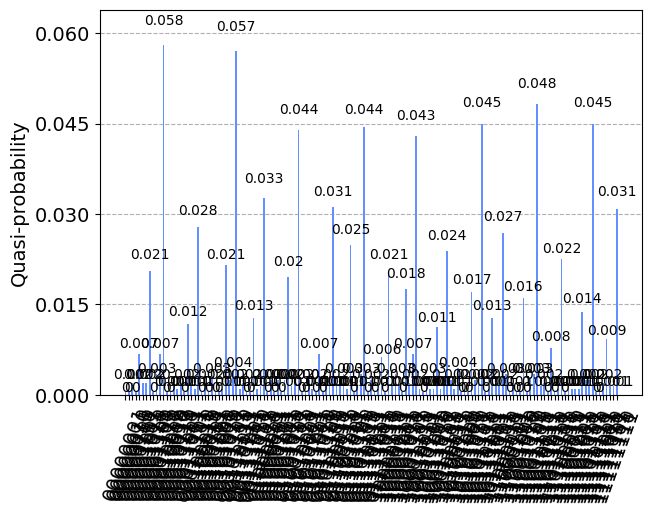

In [24]:
# Run the circuit on real hardware
counts_real = run(c, rigetti_qpu_ankaa_2)
plot_histogram(counts_real)

In [25]:
print(counts_real)

{'00011111': 57.0, '00001011': 42.0, '11101111': 92.0, '01111111': 42.0, '10001111': 88.0, '11001111': 99.0, '00101111': 117.0, '00001111': 119.0, '10011110': 3.0, '10111110': 4.0, '10001110': 14.0, '10011111': 49.0, '01001111': 90.0, '11001101': 6.0, '00111111': 67.0, '00001101': 7.0, '11011111': 46.0, '00011011': 24.0, '10100111': 9.0, '00100111': 6.0, '01011011': 14.0, '10010101': 1.0, '10001011': 36.0, '00111101': 2.0, '01101111': 91.0, '10101101': 5.0, '11101011': 28.0, '01011111': 64.0, '11101010': 2.0, '11111111': 63.0, '01101011': 51.0, '00101011': 44.0, '11001110': 7.0, '00111011': 26.0, '10101111': 92.0, '11111011': 19.0, '00101010': 2.0, '10000111': 7.0, '01101100': 1.0, '10111101': 3.0, '00011101': 3.0, '10101110': 4.0, '01101110': 7.0, '00001010': 4.0, '01001011': 40.0, '11001011': 33.0, '11101101': 5.0, '10111011': 26.0, '00000111': 14.0, '10111111': 55.0, '10010111': 6.0, '11011011': 16.0, '10101011': 35.0, '01101101': 3.0, '01100110': 3.0, '00001110': 14.0, '11100011': 

In [26]:
alice_shared_key = find_shared_key(key)
print(alice_shared_key)
# find the eight most seen states
top_8 = [key[::-1] for key, value in sorted(counts_real.items(), key=lambda item: item[1], reverse=True)[:8]]
bobs_states = top_8
bob_shared_keys = list(map(find_shared_key, bobs_states))
mismatches = []
for s in bobs_states:
    k = find_shared_key(s)
    if k != alice_shared_key:
        mismatches.append((s, k))
print(mismatches)

[1, 1, 1, 1]
[]


In [27]:
def eve(circ, n = DEFAULT_SIZE):
    # generate a random encoding basis
    basis = random_bitstring(n)

    # measure according to the encoding basis
    for i in range(n):
        if (basis[i]):
            circ.h(i)
    circ.measure_all()

    # encode again after measurement
    for i in range(n):
        if (basis[i]):
            circ.h(i)
    return basis

[0, 0, 0, 1, 1, 1, 0, 0]
[1, 0, 0, 1, 0, 1, 1, 0]
[0, 1, 1, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 1, 1, 1]


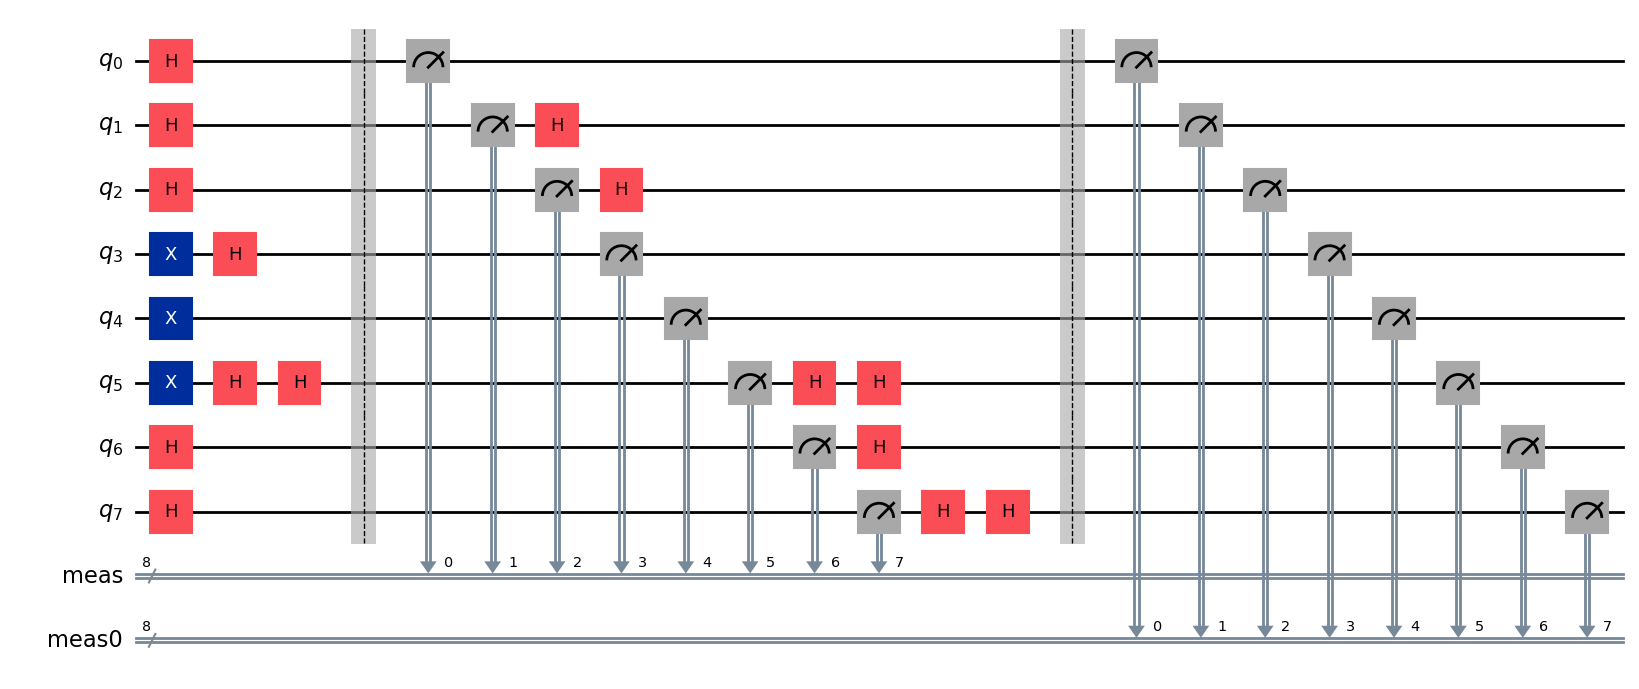

In [28]:
c = QuantumCircuit(DEFAULT_SIZE)
key, alice_basis = alice(c)
eve_basis = eve(c)
bob_basis = bob(c)

c.measure_all()

print(key)
print(alice_basis)
print(eve_basis)
print(bob_basis)
c.draw('mpl')

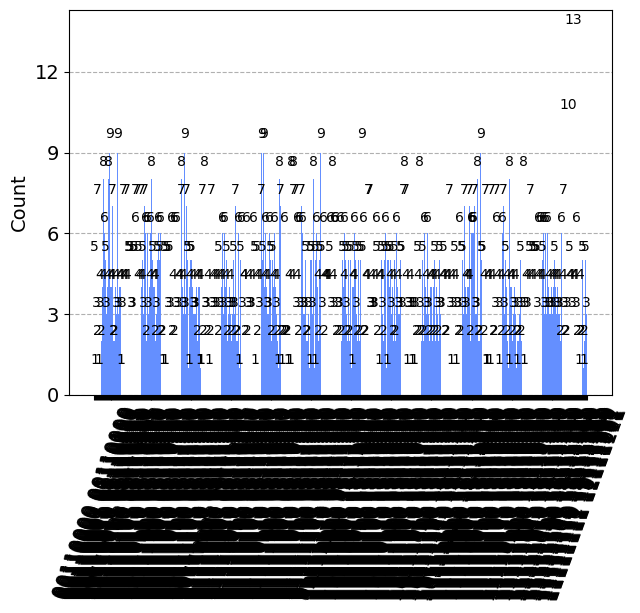

In [31]:
from qiskit_aer import AerSimulator
# Due to measuring more than once we can not run this using a local simulator. 
counts = run(c, AerSimulator())
plot_histogram(counts)

In [32]:
print(counts)

{'01111000 00111010': 8, '11110001 11110111': 8, '01110101 00110011': 4, '01110011 01110101': 6, '10111110 10111100': 7, '11111100 10111010': 4, '01110000 00110110': 3, '10111100 11111110': 2, '01110111 01110101': 3, '00111100 00111010': 5, '10110000 10110110': 4, '01111011 00111011': 6, '11110110 10110010': 4, '00111010 00111010': 2, '11110000 10110100': 7, '01110101 01110101': 9, '10111011 11111111': 4, '01110100 00110000': 3, '10110000 11110100': 3, '00110110 01110110': 2, '11111110 10111110': 4, '01111010 01111010': 2, '11110010 11110010': 4, '10110010 11110010': 9, '11111101 10111101': 2, '11110100 10110100': 7, '01111101 00111101': 5, '11110010 10110010': 2, '00111101 01111101': 1, '01111110 01111010': 6, '01110100 00110100': 3, '10111011 11111011': 3, '10110000 11110000': 6, '11111001 10111001': 4, '11110011 11110111': 2, '11111011 10111111': 4, '10110001 11110001': 4, '00110100 01110000': 5, '01111111 00111111': 6, '01110111 01110001': 6, '10111100 11111010': 4, '11111011 10111